# Preprocessing

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
import seaborn as sns
from scipy import stats
from scipy.stats.stats import pearsonr
from IPython.core.display import display, HTML
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))

In [250]:
# Load data, convert RegimeType to dummy varibles, drop unneeded columns
df_all_raw = pd.read_excel('Happiness Dataset.xlsx', sheet_name='Main')
dummy = pd.get_dummies(df_all_raw['RegimeType'])
df_all_raw = df_all_raw.drop(['Country', 'CountryCode', 'HappinessRank', 'RegimeType', 'PopulationInThousands'], axis=1)
df_all_raw = pd.concat([df_all_raw, dummy], axis=1)
df_all_raw.head()

,HappinessScore,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,DemocracyScore,ReligonImportance,FreedomOfPress,MedianAge,IndividualsUsingInternetPer100,Authoritarian,Flawed democracy,Full democracy,Hybrid regime
0,6.95,42443.47,4.2,3.4,31.7,8.68,0.40,14.60,47.1,116,0,0,1,0
1,5.96,30830.92,11.4,3.0,35.4,7.71,0.72,24.98,45.5,359,0,1,0,0
2,5.76,21617.58,8.1,2.5,25.4,7.50,0.47,22.31,44.5,143,0,1,0,0
3,5.23,18116.46,23.0,3.3,36.0,7.29,0.71,29.08,44.5,374,0,1,0,0
4,7.01,45103.33,6.2,3.3,30.5,8.29,0.55,15.33,44.0,118,0,0,1,0


In [251]:
# Check for null values
df_all_raw.isnull().any()

HappinessScore                    False
GDPPerCapita                      False
UnemploymentPercent               False
InfantMortalityRatePer1000        False
GiniIndex                         False
DemocracyScore                    False
ReligonImportance                 False
FreedomOfPress                    False
MedianAge                         False
IndividualsUsingInternetPer100    False
Authoritarian                     False
Flawed democracy                  False
Full democracy                    False
Hybrid regime                     False
dtype: bool

# Data Exploration

In [253]:
# View key stats
df_all_raw.describe()

,HappinessScore,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,DemocracyScore,ReligonImportance,FreedomOfPress,MedianAge,IndividualsUsingInternetPer100,Authoritarian,Flawed democracy,Full democracy,Hybrid regime
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,5.569697,15743.042424,8.513131,20.620202,37.816869,6.296263,0.688081,30.575960,32.324242,292.171717,0.171717,0.404040,0.181818,0.242424
std,1.128674,19958.720904,5.712065,20.386996,8.080336,1.922144,0.259039,13.363267,9.180226,393.164582,0.379054,0.493203,0.387657,0.430730
min,3.470000,315.780000,0.500000,2.300000,25.000000,1.930000,0.160000,7.820000,15.400000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,4.665000,2611.980000,5.250000,4.150000,32.350000,5.155000,0.425000,22.200000,24.500000,68.500000,0.000000,0.000000,0.000000,0.000000
50%,5.570000,7028.940000,6.800000,12.700000,36.200000,6.410000,0.760000,29.780000,32.000000,134.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000,19220.395000,10.500000,31.050000,42.950000,7.795000,0.925000,36.160000,41.150000,305.000000,0.000000,1.000000,0.000000,0.000000
max,7.540000,101305.530000,27.300000,69.800000,63.000000,9.870000,1.000000,78.920000,47.100000,2358.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

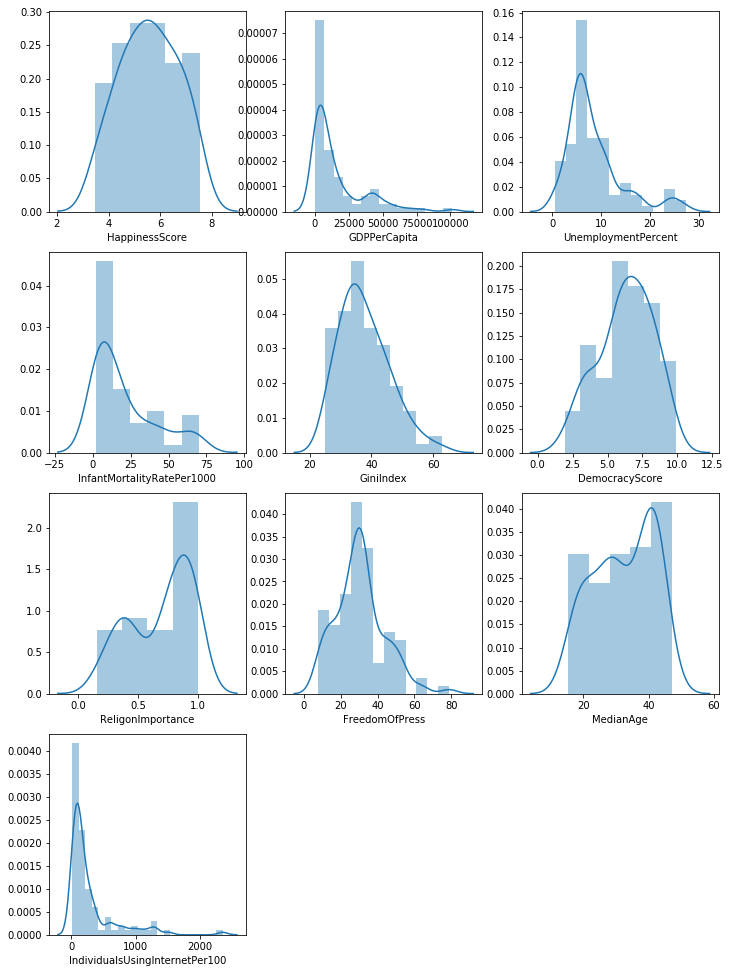

In [132]:
# View distribution of non-categorical data
df_non_cat = df_all_raw.drop(['Authoritarian', 'Flawed democracy', 'Full democracy', 'Hybrid regime'], axis=1)

fig = plt.figure()
fig, axes = plt.subplots(figsize=(12,17))
for i, col in enumerate(df_non_cat.columns, 1):
    plt.subplot(4, 3, i)
    sns.distplot(df_non_cat[col])

<Figure size 432x288 with 0 Axes>

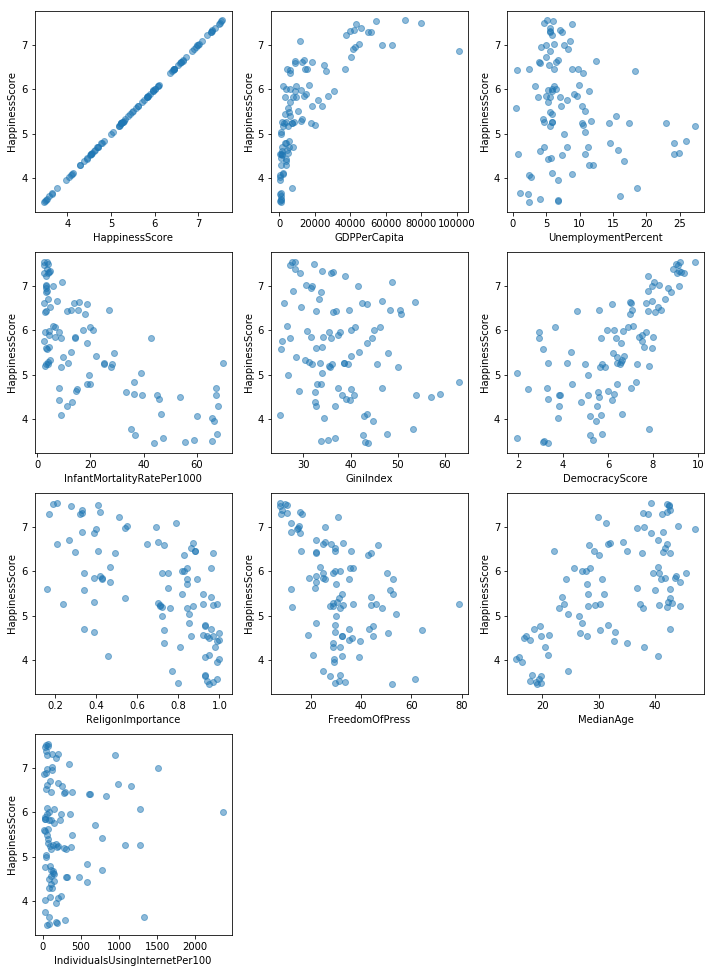

In [133]:
fig = plt.figure()
fig, axes = plt.subplots(figsize=(12,17))
for i, col in enumerate(df_non_cat.columns, 1):
    plt.subplot(4, 3, i)
    plt.scatter(df_non_cat[col], df_non_cat["HappinessScore"], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("HappinessScore")

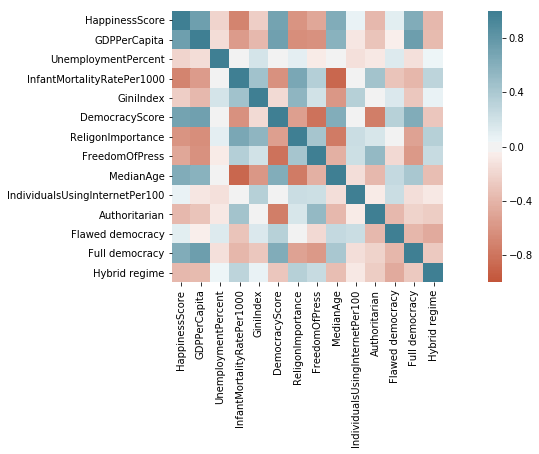

In [131]:
# View correlation matrix
corr = df_all_raw.corr()
plt.figure(figsize = (16,5))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
);

# Modeling: Linear Regression

### OLS - All Nations - All Features

In [201]:
# Create X and y. Verify dtypes. 
y = df_all_raw['HappinessScore']
X = df_all_raw.drop(['HappinessScore'], axis=1)
X.dtypes

GDPPerCapita                      float64
UnemploymentPercent               float64
InfantMortalityRatePer1000        float64
GiniIndex                         float64
DemocracyScore                    float64
ReligonImportance                 float64
FreedomOfPress                    float64
MedianAge                         float64
IndividualsUsingInternetPer100      int64
Authoritarian                       uint8
Flawed democracy                    uint8
Full democracy                      uint8
Hybrid regime                       uint8
dtype: object

In [98]:
# OLS Regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     22.11
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           2.28e-21
Time:                        02:30:41   Log-Likelihood:                -82.293
No. Observations:                  99   AIC:                             190.6
Df Residuals:                      86   BIC:                             224.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.2597      1.156      3.686      0.000       1.963       6.557
GDPPerCapita                    1.421e-05   6.02e-06      2.360      0.021    2.24e-06    2.62e-05
UnemploymentPercent               -0.0329      0.012     -2.798      0.006      -0.056      -0.010
InfantMortalityRatePer1000        -0.0273      0.007     -3.934      0.000      -0.041      -0.013
GiniIndex                          0.0235      0.012      2.038      0.045       0.001       0.046
DemocracyScore                     0.0461      0.159      0.289      0.773      -0.271       0.363
ReligonImportance                 -0.2875      0.431     -0.667      0.507      -1.145       0.570
FreedomOfPress                     0.0012      0.009      0.130      0.897      -0.017       0.020
MedianAge                         -0.0049      0.018     -0.278      0.782      -0.040       0.030
IndividualsUsingInternetPer100     0.0001      0.000      0.813      0.419      -0.000       0.001
Authoritarian                      0.9026      0.317      2.845      0.006       0.272       1.533
Flawed democracy                   0.9437      0.424      2.226      0.029       0.101       1.786
Full democracy                     1.5920      0.554      2.876      0.005       0.492       2.692
Hybrid regime                      0.8213      0.281      2.927      0.004       0.263       1.379
==============================================================================
Omnibus:                        2.763   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.118
Skew:                          -0.292   Prob(JB):                        0.347
Kurtosis:                       3.414   Cond. No.                     2.22e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.29e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### OLS - All Nations - Best Features

In [202]:
# Remove features with p-values greater than 0.05
X_best = X.drop(['DemocracyScore', 'ReligonImportance', 'FreedomOfPress', 
                 'MedianAge', 'IndividualsUsingInternetPer100'], axis=1)

In [203]:
# OLS Regression with best features
X_best = sm.add_constant(X_best)
model_best = sm.OLS(y, X_best).fit()
model_best.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     39.35
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           6.88e-25
Time:                        22:53:55   Log-Likelihood:                -83.006
No. Observations:                  99   AIC:                             182.0
Df Residuals:                      91   BIC:                             202.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.1936      0.276     15.197      0.000       3.645       4.742
GDPPerCapita                1.585e-05   5.21e-06      3.042      0.003     5.5e-06    2.62e-05
UnemploymentPercent           -0.0362      0.011     -3.366      0.001      -0.058      -0.015
InfantMortalityRatePer1000    -0.0282      0.004     -6.433      0.000      -0.037      -0.019
GiniIndex                      0.0264      0.009      2.938      0.004       0.009       0.044
Authoritarian                  0.8040      0.151      5.315      0.000       0.504       1.104
Flawed democracy               0.9650      0.130      7.436      0.000       0.707       1.223
Full democracy                 1.6469      0.220      7.492      0.000       1.210       2.084
Hybrid regime                  0.7777      0.131      5.951      0.000       0.518       1.037
==============================================================================
Omnibus:                        2.543   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                1.924
Skew:                          -0.298   Prob(JB):                        0.382
Kurtosis:                       3.332   Cond. No.                     2.44e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### OLS - All Nations - Best Features Z-Scores

In [244]:
cols = list(X_best.columns)
X_best[cols]

# now iterate over the remaining columns and create a new zscore column
for col in cols:
    col_zscore = col + '_zscore'
    X_best[col_zscore] = (X_best[col] - X_best[col].mean())/X_best[col].std(ddof=0)

,const,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,Authoritarian,Flawed democracy,Full democracy,Hybrid regime,const_zscore,GDPPerCapita_zscore,UnemploymentPercent_zscore,InfantMortalityRatePer1000_zscore,GiniIndex_zscore,Authoritarian_zscore,Flawed democracy_zscore,Full democracy_zscore,Hybrid regime_zscore
0,1.0,42443.47,4.2,3.4,31.7,0,0,1,0,NaN,1.344591,-0.758934,-0.848965,-0.760859,-0.455321,-0.823387,2.121320,-0.565685
1,1.0,30830.92,11.4,3.0,35.4,0,1,0,0,NaN,0.759801,0.507970,-0.868685,-0.300627,-0.455321,1.214496,-0.471405,-0.565685
2,1.0,21617.58,8.1,2.5,25.4,0,1,0,0,NaN,0.295832,-0.072694,-0.893335,-1.544498,-0.455321,1.214496,-0.471405,-0.565685
3,1.0,18116.46,23.0,3.3,36.0,0,1,0,0,NaN,0.119521,2.549095,-0.853895,-0.225995,-0.455321,1.214496,-0.471405,-0.565685
4,1.0,45103.33,6.2,3.3,30.5,0,0,1,0,NaN,1.478537,-0.407016,-0.853895,-0.910124,-0.455321,-0.823387,2.121320,-0.565685


In [248]:
X_best_z = X_best.drop(['const', 'const_zscore', 'GDPPerCapita', 'UnemploymentPercent', 'InfantMortalityRatePer1000', 
             'GiniIndex','Authoritarian', 'Flawed democracy', 'Full democracy', 'Hybrid regime'], axis=1)
X_best_z.head()

,GDPPerCapita_zscore,UnemploymentPercent_zscore,InfantMortalityRatePer1000_zscore,GiniIndex_zscore,Authoritarian_zscore,Flawed democracy_zscore,Full democracy_zscore,Hybrid regime_zscore
0,1.344591,-0.758934,-0.848965,-0.760859,-0.455321,-0.823387,2.121320,-0.565685
1,0.759801,0.507970,-0.868685,-0.300627,-0.455321,1.214496,-0.471405,-0.565685
2,0.295832,-0.072694,-0.893335,-1.544498,-0.455321,1.214496,-0.471405,-0.565685
3,0.119521,2.549095,-0.853895,-0.225995,-0.455321,1.214496,-0.471405,-0.565685
4,1.478537,-0.407016,-0.853895,-0.910124,-0.455321,-0.823387,2.121320,-0.565685


In [255]:
# OLS Regression with z-scores of best features
X_best_z = sm.add_constant(X_best_z)
model_best_z = sm.OLS(y, X_best_z).fit()
model_best_z.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     39.35
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           6.88e-25
Time:                        23:43:42   Log-Likelihood:                -83.006
No. Observations:                  99   AIC:                             182.0
Df Residuals:                      91   BIC:                             202.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 5.5697      0.059     94.942      0.000       5.453       5.686
GDPPerCapita_zscore                   0.3148      0.103      3.042      0.003       0.109       0.520
UnemploymentPercent_zscore           -0.2057      0.061     -3.366      0.001      -0.327      -0.084
InfantMortalityRatePer1000_zscore    -0.5714      0.089     -6.433      0.000      -0.748      -0.395
GiniIndex_zscore                      0.2125      0.072      2.938      0.004       0.069       0.356
Authoritarian_zscore                 -0.0840      0.059     -1.419      0.159      -0.202       0.034
Flawed democracy_zscore              -0.0303      0.045     -0.676      0.501      -0.119       0.059
Full democracy_zscore                 0.2392      0.076      3.159      0.002       0.089       0.390
Hybrid regime_zscore                 -0.1067      0.053     -2.007      0.048      -0.212      -0.001
==============================================================================
Omnibus:                        2.543   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                1.924
Skew:                          -0.298   Prob(JB):                        0.382
Kurtosis:                       3.332   Cond. No.                     4.85e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### OLS - Developed (High HDI) Nations - All Features

In [228]:
#df_hdi = pd.read_excel('Happiness Dataset.xlsx', sheet_name='HDI')
df_hdi = df_all_raw.drop(['DemocracyScore', 'ReligonImportance', 'FreedomOfPress', 
                 'MedianAge', 'IndividualsUsingInternetPer100'], axis=1)

df_hdi = df_hdi[df_hdi['GDPPerCapita']>20000]

df_hdi.head()

,HappinessScore,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,Authoritarian,Flawed democracy,Full democracy,Hybrid regime
0,6.95,42443.47,4.2,3.4,31.7,0,0,1,0
1,5.96,30830.92,11.4,3.0,35.4,0,1,0,0
2,5.76,21617.58,8.1,2.5,25.4,0,1,0,0
4,7.01,45103.33,6.2,3.3,30.5,0,0,1,0
10,6.40,26622.30,18.3,2.9,36.2,0,0,1,0


In [229]:
# Create X and y. Verify dtypes. 
y_hdi = df_hdi['HappinessScore']
X_hdi = df_hdi.drop(['HappinessScore'], axis=1)
X_hdi.dtypes

GDPPerCapita                  float64
UnemploymentPercent           float64
InfantMortalityRatePer1000    float64
GiniIndex                     float64
Authoritarian                   uint8
Flawed democracy                uint8
Full democracy                  uint8
Hybrid regime                   uint8
dtype: object

In [230]:
# OLS Regression
X_hdi = sm.add_constant(X_hdi)
model = sm.OLS(y_hdi, X_hdi).fit()
predictions = model.predict(X_hdi)
model.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/_distn_infrastruct

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     6.159
Date:                Thu, 22 Aug 2019   Prob (F-statistic):            0.00170
Time:                        23:10:50   Log-Likelihood:                -8.9135
No. Observations:                  24   AIC:                             29.83
Df Residuals:                      18   BIC:                             36.90
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.4789      0.523      8.570      0.000       3.381       5.577
GDPPerCapita                 6.19e-06   5.63e-06      1.099      0.286   -5.64e-06     1.8e-05
UnemploymentPercent           -0.0675      0.034     -2.009      0.060      -0.138       0.003
InfantMortalityRatePer1000    -0.0706      0.042     -1.674      0.112      -0.159       0.018
GiniIndex                      0.0168      0.023      0.743      0.467      -0.031       0.064
Authoritarian              -2.327e-16    3.9e-17     -5.968      0.000   -3.15e-16   -1.51e-16
Flawed democracy               1.9766      0.299      6.601      0.000       1.347       2.606
Full democracy                 2.5023      0.261      9.578      0.000       1.953       3.051
Hybrid regime                       0          0        nan        nan           0           0
==============================================================================
Omnibus:                        1.704   Durbin-Watson:                   1.416
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.247
Skew:                          -0.328   Prob(JB):                        0.536
Kurtosis:                       2.097   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### OLS - Developed (High HDI) Nations - Best Features

In [256]:
# Remove previously insignificant features to see if we can get p-vales below 0.05
X_hdi_best = X_hdi.drop(['GDPPerCapita', 'GiniIndex', 'Hybrid regime'], axis=1)

In [258]:
# OLS Regression
X_hdi_best = sm.add_constant(X_hdi_best)
model_hdi_best = sm.OLS(y_hdi, X_hdi_best).fit()
predictions = model_hdi_best.predict(X_hdi_best)
model_hdi_best.summary()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     9.421
Date:                Thu, 22 Aug 2019   Prob (F-statistic):           0.000436
Time:                        23:44:54   Log-Likelihood:                -10.310
No. Observations:                  24   AIC:                             28.62
Df Residuals:                      20   BIC:                             33.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.1028      0.224     22.800      0.000       4.636       5.570
UnemploymentPercent           -0.0807      0.030     -2.686      0.014      -0.143      -0.018
InfantMortalityRatePer1000    -0.0766      0.040     -1.892      0.073      -0.161       0.008
Authoritarian              -2.438e-16   1.19e-17    -20.476      0.000   -2.69e-16   -2.19e-16
Flawed democracy               2.2647      0.179     12.621      0.000       1.890       2.639
Full democracy                 2.8381      0.108     26.212      0.000       2.612       3.064
==============================================================================
Omnibus:                        2.022   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                1.575
Skew:                          -0.459   Prob(JB):                        0.455
Kurtosis:                       2.145   Cond. No.                     1.08e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.56e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Validating Linear Regression Assumptions

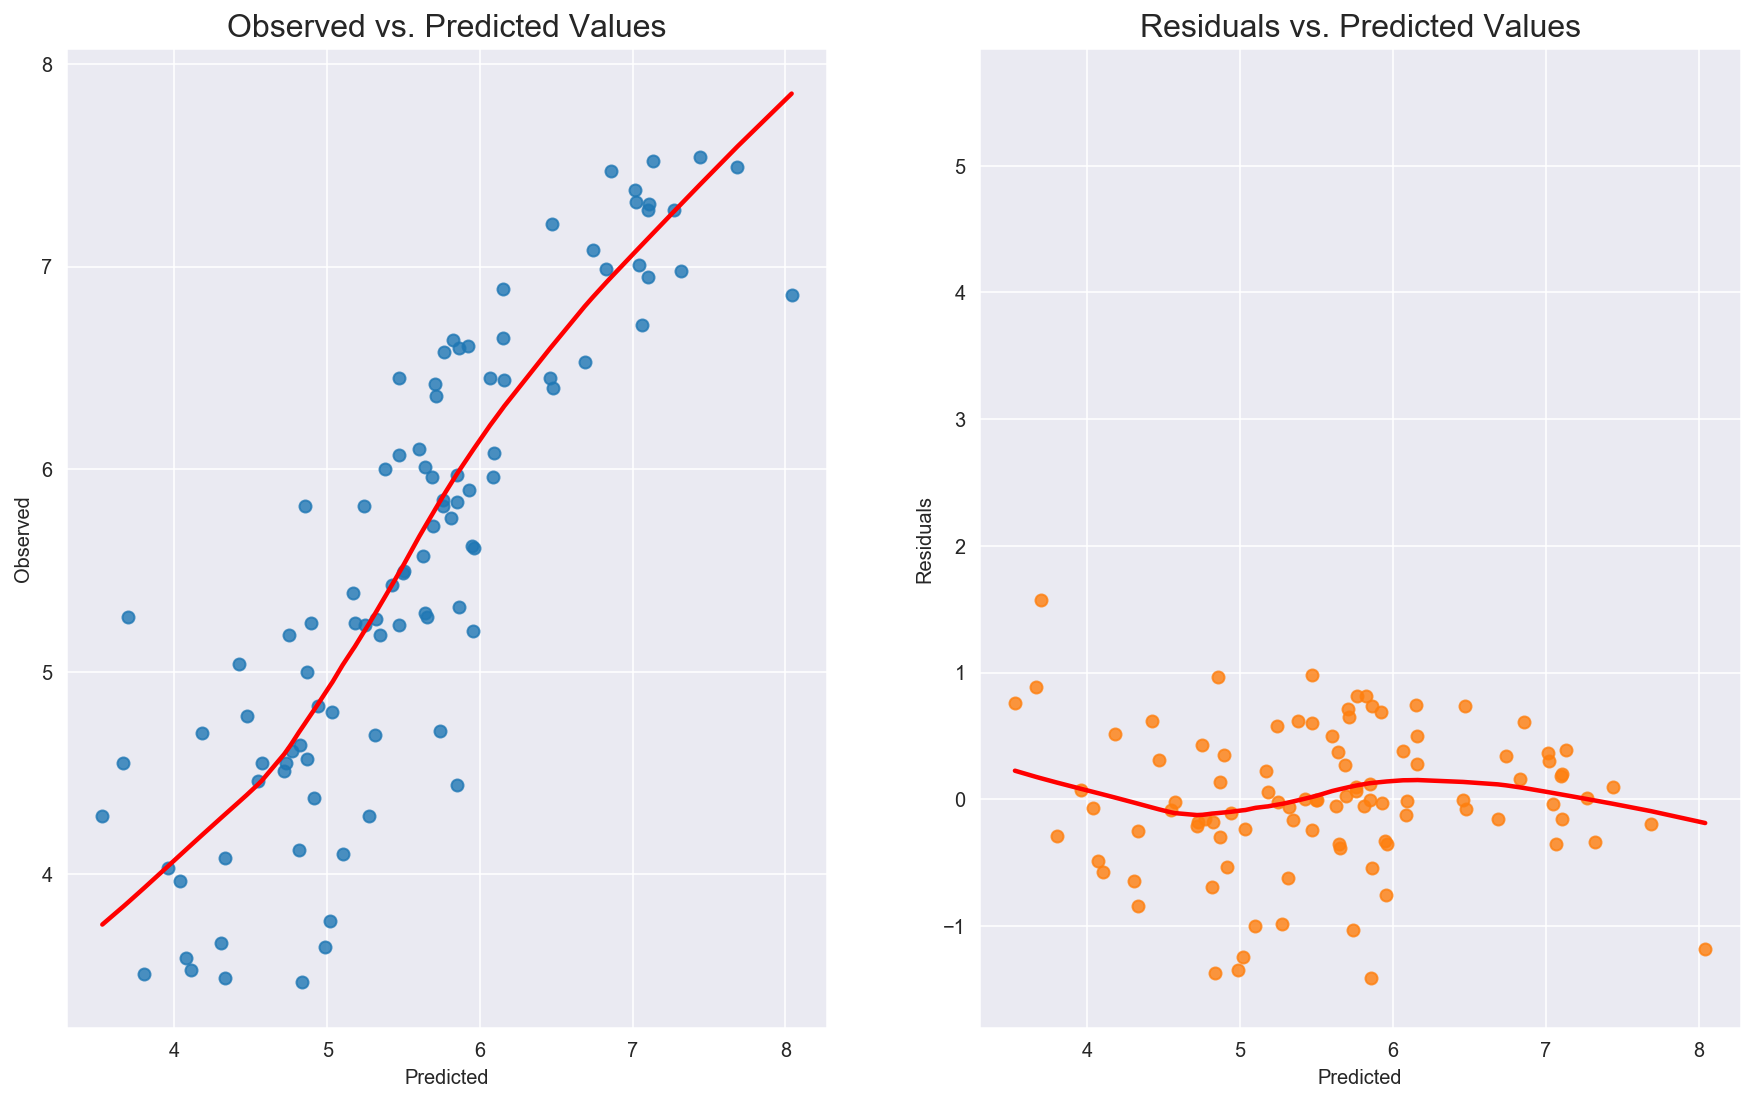

In [180]:
# Assumption 1: Linearity of the model

%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(model_best, y)    

In [179]:
# Assumption 2: Mean of residuals is zero
model_best.resid.mean()

-2.8260222445003984e-16

In [177]:
# Assumption 3: No Multicollinearity (VIF under 5)
vif = [variance_inflation_factor(X_best.values, i) for i in range(X_best.shape[1])]
pd.DataFrame({'vif': vif}, index=X_best.columns).T

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,const,GDPPerCapita,UnemploymentPercent,InfantMortalityRatePer1000,GiniIndex,Authoritarian,Flawed democracy,Full democracy,Hybrid regime
vif,0.0,3.112029,1.085335,2.292655,1.520027,inf,inf,inf,inf



 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  9.112831
p-value                        0.332867
f-value                        1.317950
f p-value                      0.250872

 Goldfeld-Quandt test ----
                value
F statistic  1.520531
p-value      0.090264

 Residuals plots ----


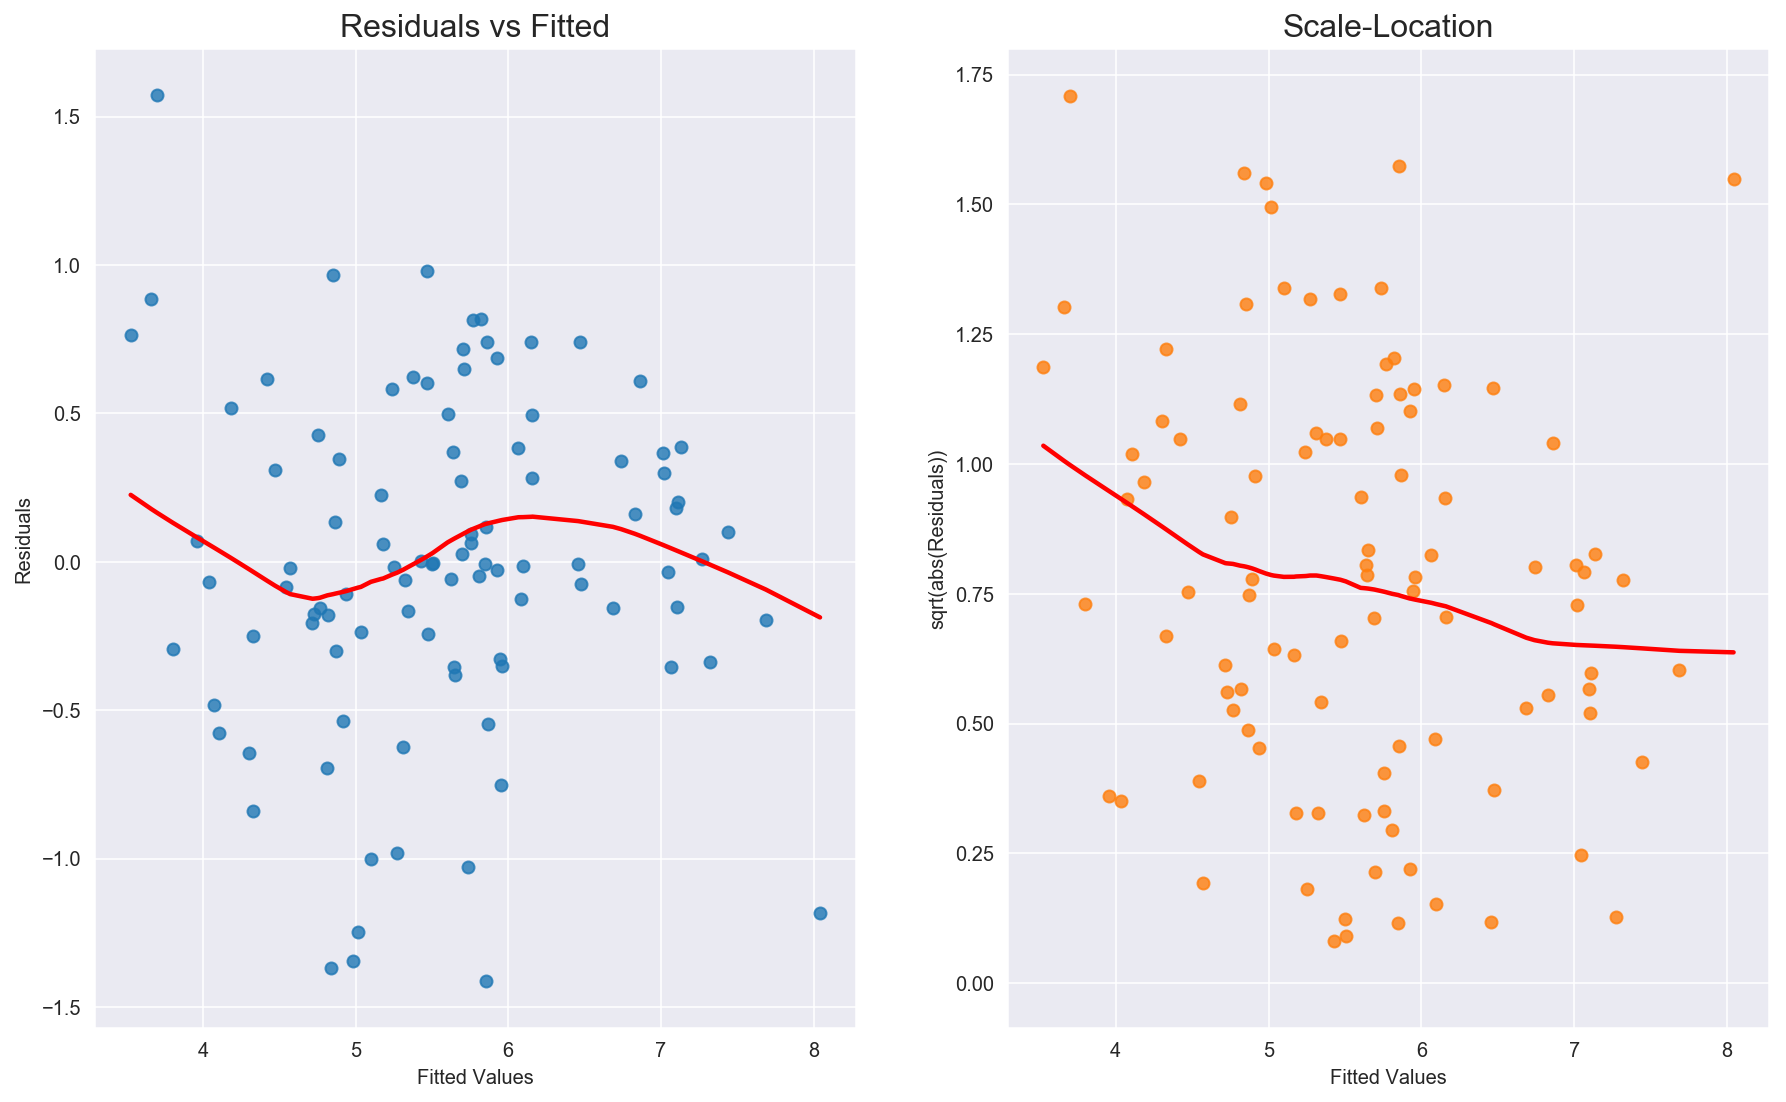

In [178]:
# Assumption 4: Homoscedasticity of residuals (p-value greater than 0.05)

%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(model_best)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


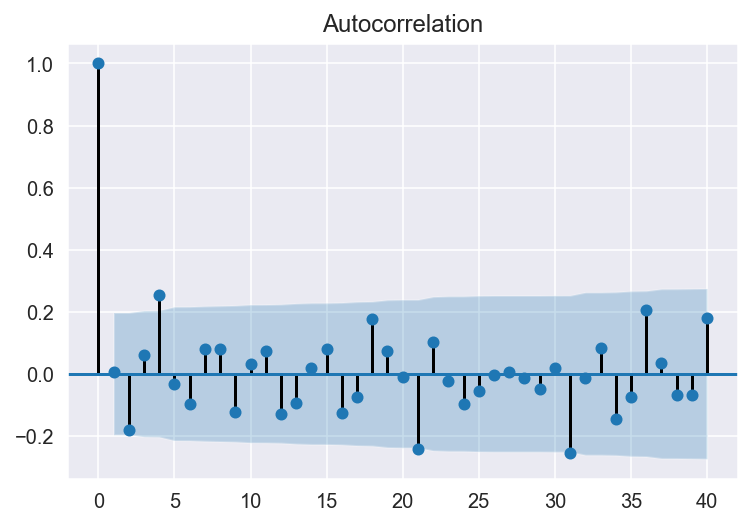

In [192]:
# Assumption 5: No auto-correlation

# Durbin-Watson score of 1.987 suggests there is no auto-correlation in the data.

# We can also plot residuals
acf = smt.graphics.plot_acf(model_best.resid, lags=40 , alpha=0.05)
acf.show()

In [200]:
# Assumption 6: Pearson correlation coefficient between each feature and residuals

for column in X_best.columns:
    corr_test = pearsonr(X_best[column], model_best.resid)
    print('Variable: ' + str(column) + '--- correlation: ' + str(corr_test[0]) + ', p-value: ' + str(corr_test[1]))

Variable: const--- correlation: nan, p-value: 1.0
Variable: GDPPerCapita--- correlation: 8.690556070826806e-16, p-value: 1.0
Variable: UnemploymentPercent--- correlation: -6.574185331844213e-15, p-value: 1.0
Variable: InfantMortalityRatePer1000--- correlation: -7.496497710633917e-16, p-value: 1.0
Variable: GiniIndex--- correlation: 1.0354315906534682e-15, p-value: 1.0
Variable: Authoritarian--- correlation: -6.887670082358569e-16, p-value: 1.0
Variable: Flawed democracy--- correlation: 5.446699115205636e-16, p-value: 1.0
Variable: Full democracy--- correlation: 1.0659109997012089e-16, p-value: 1.0
Variable: Hybrid regime--- correlation: -8.869873254177766e-17, p-value: 1.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Jarque-Bera test ---- statistic:  1.924012720120315 p-value:  0.3821254351301814
Shapiro-Wilk test ---- statistic: 0.9774287939071655 p-value:  0.08666591346263885
Kolmogorov-Smirnov test ---- statistic: 0.17975279229513935 p-value: 0.002858441248810184
Anderson-Darling test ---- statistic: 0.7443658936448969 5% critical value: 0.758
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


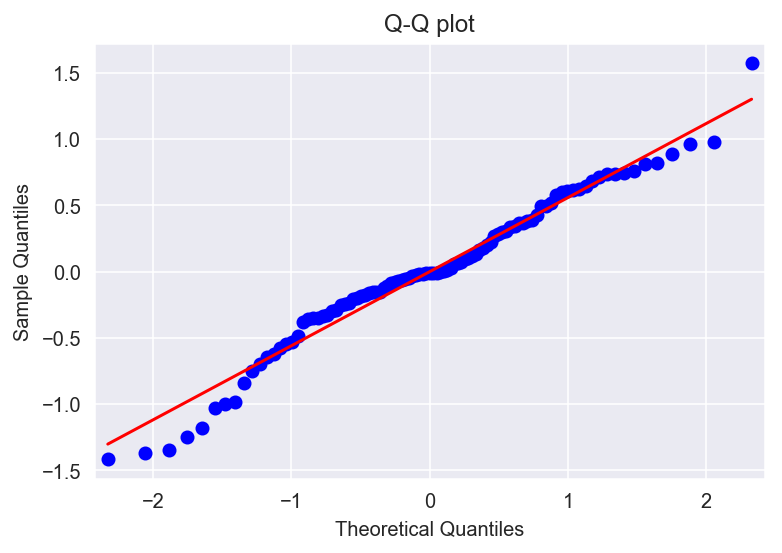

In [199]:
# Assumption 7: Normality of residuals

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print('Jarque-Bera test ---- statistic: ', jb[0], 'p-value: ', jb[1])
    print('Shapiro-Wilk test ---- statistic:', sw[0], 'p-value: ', sw[1])
    print('Kolmogorov-Smirnov test ---- statistic:', ks.statistic, 'p-value:', ks.pvalue)
    print('Anderson-Darling test ---- statistic:', ad.statistic, '5% critical value:', ad.critical_values[2])
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(model_best)